In [1]:
import os;
from google.colab import drive
drive.mount('/content/drive', force_remount=True);


path = "/content/drive/Shared drives/Computational Optics Group/Yizhou_Lu_FLIM/DMD simulation";

os.chdir(path);
from PMT_compressed_sensing_simu import Compressed_sensing_PMT as CSP;

path = "/content/drive/Shared drives/Computational Optics Group/Yizhou_Lu_FLIM/Eigen Face";
os.chdir(path);


import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

plt.style.use("seaborn-ticks")

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


In [2]:
## convert the dataframe into np.array
df = pd.read_csv('face_data.csv');
X = df.drop('target', axis=1);
X = X.values;
y = df['target'];
y = y.values;

print(X.shape)
print(len(y))

(400, 4096)
400


In [3]:
## check the eigen_value and eigen vector
def Check_Eigen(X):
    X_centered = X - np.mean(X, axis = 0);
    S = X_centered.T.dot(X_centered) / (len(X_centered)-1);
    eigen_val, eigen_vec = np.linalg.eig(S);
    return eigen_val, eigen_vec;

    '''
    model = PCA().fit(X);
    I = np.eye(len(X[0,:]));
    eigen_val = model.explained_variance_;
    eigen_vec = model.transform(I);
    return eigen_val, eigen_vec;
    '''

eigen_val, eigen_vec = Check_Eigen(X);
print(eigen_val.shape)
print(eigen_vec.shape)

(4096,)
(4096, 4096)


In [4]:
class Strategy(object):
    def __init__(self):
        self.prop = {};

    def add_item(self, name, item):
        if name not in self.prop:
            self.prop[name] = item;
        else:
            print("Item name already exists.");
    
    def rm_item(self, name):
        if name in self.prop:
            del self.prop[name];
        else:
            print("Item name doesn't exist.")

In [5]:
X_train

In [6]:
N_max = 20;
max_val = 5
light_level_index = np.arange(N_max).astype(float)/(N_max-1) * (max_val + 2) - 2;
light_level_list = 10**light_level_index;

Recons = Strategy();
Recons.add_item("name", "Reconstruction")
Recons.add_item("data", X);
Recons.add_item("label",y);
Recons.add_item("light_level_list", light_level_list);
Recons.add_item("Accuracy", []);
Recons.add_item("n_iter", 10); ## multiple iterations to get the accuracy 

Non_Recons = Strategy();
Non_Recons.add_item("name", "Non-Reconstruction")
Non_Recons.add_item("data", X);
Non_Recons.add_item("label",y);
Non_Recons.add_item("light_level_list", light_level_list);
Non_Recons.add_item("Accuracy", []);
Non_Recons.add_item("n_iter", 10); ## multiple iterations to get the accuracy 

In [7]:
n_iter = 10;

def PLOT(X:np.ndarray, Y: np.ndarray, name: list, Xlabel = 'X', Ylabel = 'Y'):
    '''
    X = np.array(X);
    Y = np.array(Y);
    X = X.reshape(len(name), -1);
    Y = Y.reshape(len(name), -1);
    '''

    
    plt.figure(facecolor='white');
    for i in range(len(name)):
        plt.plot(X[i], Y[i], label = name[i], marker = 'x');
        
    plt.xlabel(Xlabel);
    plt.ylabel(Ylabel);
    plt.legend();
    plt.show();



In [8]:
class Eigen_FLIM(object):
    def __init__(self, X , y, light_level_list):
        self.X = X;
        self.y = y;
        self.light_level_list = light_level_list;

    ## method 1
    def data_spliting(self):
        self.X_train, self.X_test, self.y_train, self.y_test = \
            train_test_split(self.X, self.y);    
    
    ## method 2
    def get_model(self):

        def get_greatest(eigen_val, threshold = 0.02): ## eigen values are sorted!
            for i in range(len(eigen_val)):
                if eigen_val[i] < eigen_val[0] * threshold:
                    break;
            return i;

        pca = PCA().fit(self.X_train);
        N = get_greatest(pca.explained_variance_, threshold=0.02);
        pca = PCA(n_components = N).fit(X);
        self.model = pca;

    ## method 3
    def transform(self, x):
        return self.model.transform(x);

    def add_poisson(self, x, light_level:float):
        return np.random.poisson(x * light_level) / light_level;

    ## method 4
    def train(self, X_train_pca, y_train):        
        self.classifier = SVC().fit(X_train_pca, y_train);

    def predict(self, X_test_pca):
        self.prediction = self.classifier.predict(X_test_pca);

    def get_accuracy(self, pred, y_test):
        return np.mean(pred == y_test);


In [9]:
## Non_Recons:
Poisson = True;
Obj = Non_Recons;
Obj.prop['Accuracy'] = [];
Method = Eigen_FLIM(Obj.prop['data'], Obj.prop['label'], Obj.prop['light_level_list']);
for light_level in Method.light_level_list:
    accuracy = [];
    for i in range(Obj.prop["n_iter"]):

        Method.data_spliting();
        
        Method.get_model();

        X_train_pca = Method.transform(Method.X_train);
        
        Method.train(X_train_pca, Method.y_train);

        #noise:
        if Poisson:
            X_test = ( Method.add_poisson(Method.X_test, light_level));
        else:
            X_test = (Method.X_test);
        X_test_pca = Method.transform(X_test);

        Method.predict(X_test_pca);
        accuracy.append(Method.get_accuracy(Method.prediction, Method.y_test));
    
    Obj.prop['Accuracy'].append(np.mean(accuracy));




In [10]:
## Non_Recons:
Poisson = True;
Obj = Non_Recons;
Obj.prop['Accuracy'] = [];
Method = Eigen_FLIM(Obj.prop['data'], Obj.prop['label'], Obj.prop['light_level_list']);
for light_level in Method.light_level_list:
    accuracy = [];
    for i in range(Obj.prop["n_iter"]):

        Method.data_spliting();
        
        Method.get_model();

        X_train_pca = Method.transform(Method.X_train);
        
        Method.train(X_train_pca, Method.y_train);

        #noise:
        if Poisson:
            X_test = ( Method.add_poisson(Method.X_test, light_level));
        else:
            X_test = (Method.X_test);
        X_test_pca = Method.transform(X_test);

        Method.predict(X_test_pca);
        accuracy.append(Method.get_accuracy(Method.prediction, Method.y_test));
    
    Obj.prop['Accuracy'].append(np.mean(accuracy));

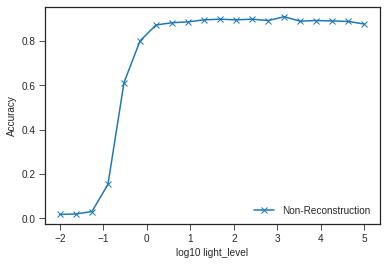

In [11]:
PLOT([np.log10(Obj.prop['light_level_list'])], [Obj.prop['Accuracy']], name = [Obj.prop['name']], Xlabel="log10 light_level", Ylabel="Accuracy");

Test for compressed sensing  
$y = Mx$  
The question is , if $x$ sparse in Eigen_vector

In [12]:
## TEst for CS
pmt = CSP();
M = np.ceil(np.sign(pmt.DCT_Matrix(64**2))/2);
M_inv = np.linalg.pinv(M);



In [57]:
domain = eigen_vec

X_mean = np.mean(X, axis = 0)

coe = (X_select - X_mean).dot(domain);

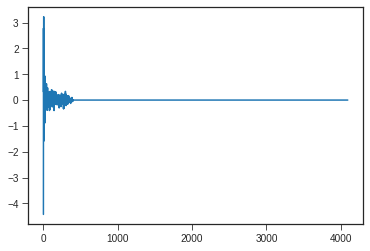

In [58]:
plt.figure(facecolor='white');
plt.plot(coe[:]);
plt.show();

In [65]:
threshold = 1e-1
print(len(np.where(abs(coe) > threshold)[0]))
print(len(np.where(abs(coe) > threshold)[0])/len(coe))
coe[np.where(abs(coe) < threshold)] = 0

207
0.050537109375


In [66]:
X_recon = coe.dot((eigen_vec.T)) + X_mean;
print(np.mean((X_recon - X_select)**2))

(0.00011963950607159409+0j)


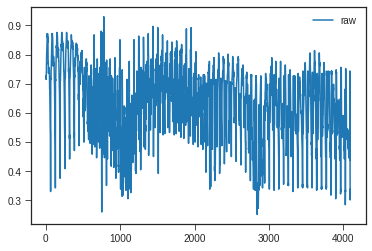

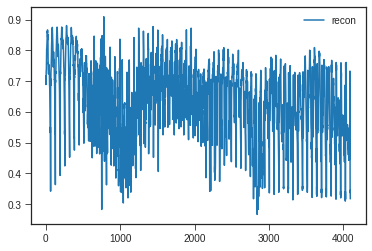

In [67]:
plt.figure(facecolor='white');
plt.plot(X_select[:], label = 'raw');
#plt.plot(X_recon, label = 'recon');
plt.legend();
plt.show();

plt.figure(facecolor='white');
#plt.plot(X_select, label = 'raw');
plt.plot(X_recon[:], label = 'recon');
plt.legend();
plt.show();

In [30]:
## no idea about the COMPLEX

No idea about the complex  
and it seems to be a good way?